+------------+------+--------+-----------+------------+----------------+--------+-------+-----+-----------+
|danceability|energy|loudness|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|
+------------+------+--------+-----------+------------+----------------+--------+-------+-----+-----------+
|          11|     1|       0|          0|           0|               0|       0|      0|    0|          0|
+------------+------+--------+-----------+------------+----------------+--------+-------+-----+-----------+

+----------+-----+
|     genre|count|
+----------+-----+
|electronic| 1721|
|       pop| 1250|
|      rock| 1134|
|    reggae| 1038|
|     blues| 1034|
|    hiphop| 1023|
|      jazz| 1001|
| classical|  961|
+----------+-----+



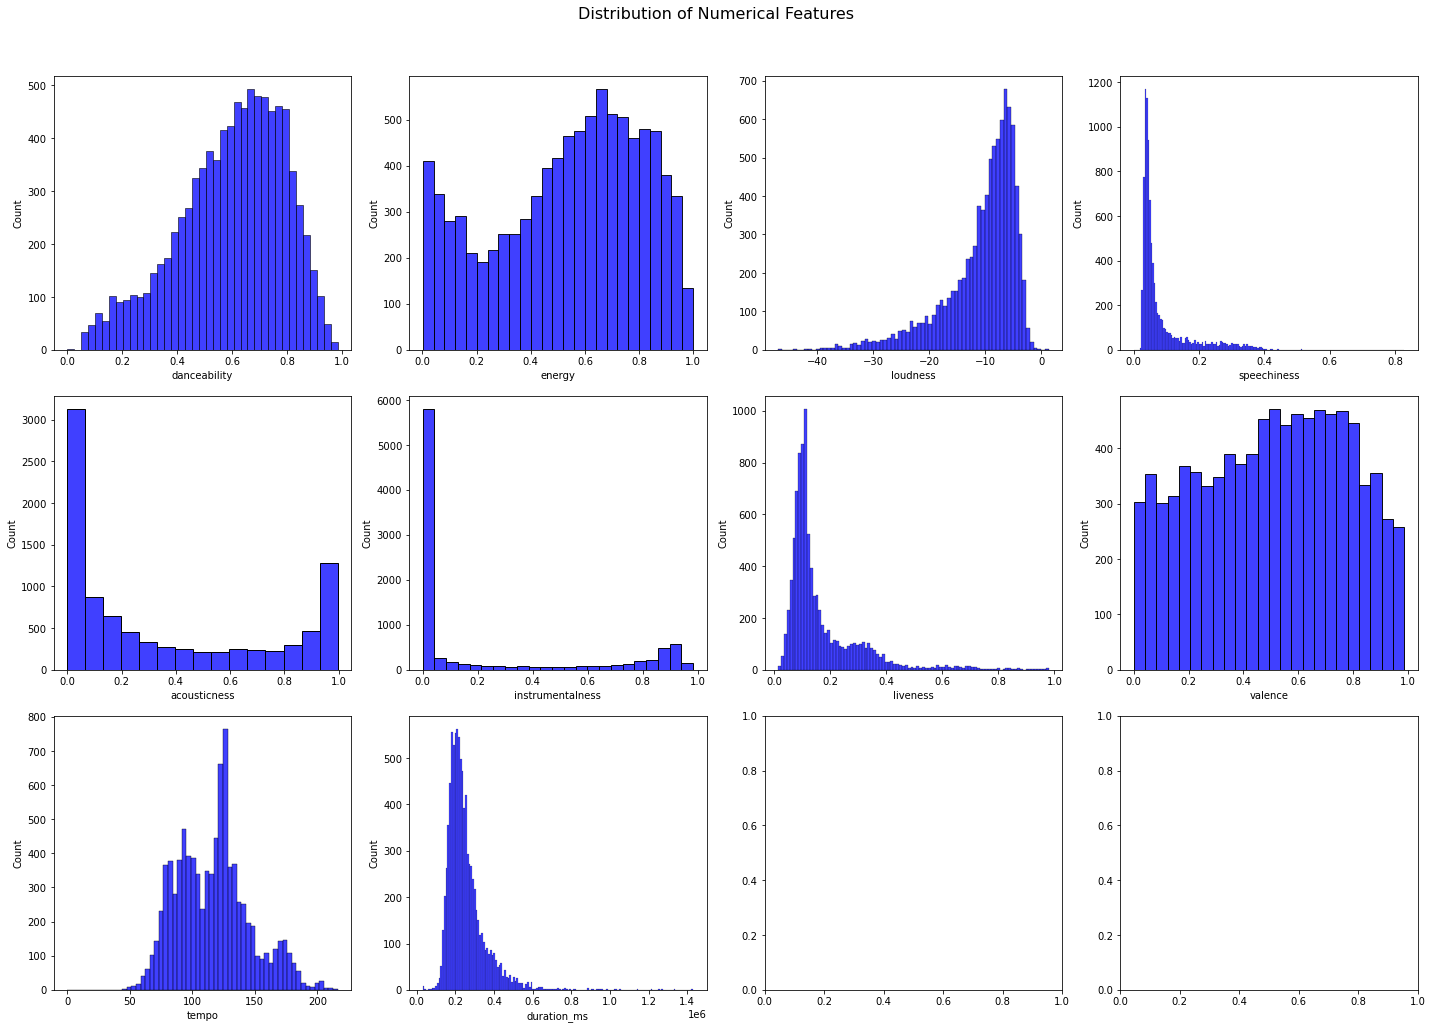

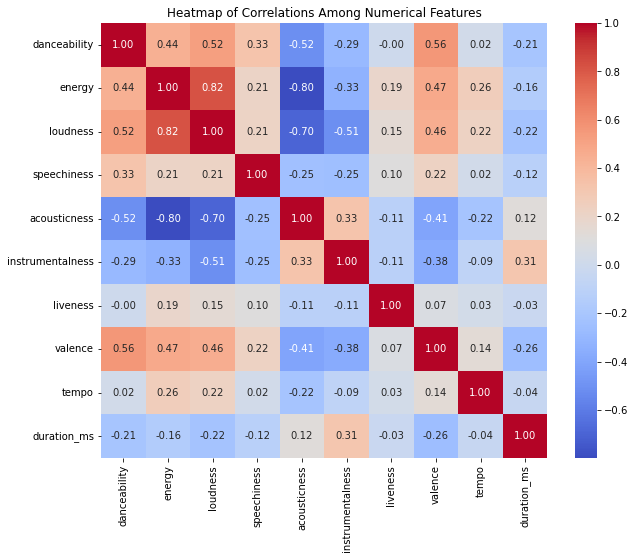

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count
import seaborn as sns
import matplotlib.pyplot as plt

# Start Spark session
spark = SparkSession.builder.appName("Spotify Data Cleanup and Analysis").getOrCreate()

# Load dataset
df = spark.read.csv("../data/spotify2.csv", header=True, inferSchema=True)

# Convert numerical variables stored as strings to floats
numerical_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
for feature in numerical_features:
    df = df.withColumn(feature, col(feature).cast('float'))

# Distribution Analysis (Categorical)
categorical_features = ['key', 'mode', 'time_signature', 'genre']
for cat in categorical_features:
    df.groupBy(cat).count().orderBy('count', ascending=False)

# Now check for nulls which might indicate casting failures
df.select([count(when(col(c).isNull(), c)).alias(c) for c in numerical_features]).show()

# Drop rows with missing values in key fields
df = df.na.drop(subset=['danceability', 'energy'])

# Filter out non-standard genre entries
standard_genres = ['pop', 'blues', 'electronic', 'hiphop', 'jazz', 'rock', 'reggae', 'classical']
df = df.filter(col('genre').isin(standard_genres))
df.groupBy('genre').count().orderBy('count', ascending=False).show()

# Collect data for visualization
pdf = df.toPandas()

# Plotting histograms for all numerical variables
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
fig.suptitle('Distribution of Numerical Features', fontsize=16)
for i, col_name in enumerate(numerical_features):
    sns.histplot(pdf[col_name], ax=axes[i//4, i%4], kde=False, color='blue')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plotting a heatmap for correlations among numerical variables
corr = pdf[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap of Correlations Among Numerical Features')
plt.show()

from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer, Imputer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# String indexer for the genre column
labelIndexer = StringIndexer(inputCol="genre", outputCol="indexedLabel").fit(df)

# Assemble features into a feature vector, ensure it's done only once
assembler = VectorAssembler(inputCols=numerical_features, outputCol="features")
df = assembler.transform(df)

In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer, Imputer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Assume the Spark session is already created and 'df' is already loaded and processed as needed

# Impute missing values using the mean
imputer = Imputer(inputCols=numerical_features, outputCols=["{}_imputed".format(c) for c in numerical_features])
df = imputer.fit(df).transform(df)

# Ensure no redundant 'features' column exists before transformation
if 'features' in df.columns:
    df = df.drop('features')

# Setup the features and label for machine learning
assembler = VectorAssembler(inputCols=["{}_imputed".format(c) for c in numerical_features], outputCol="features")
labelIndexer = StringIndexer(inputCol="genre", outputCol="indexedLabel").fit(df)

# Assemble the pipeline with RandomForest classifier
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features", numTrees=50)
pipeline = Pipeline(stages=[labelIndexer, assembler, rf])

# Parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [20, 50, 100])\
    .addGrid(rf.maxDepth, [5, 10, 15])\
    .addGrid(rf.impurity, ["entropy", "gini"])\
    .build()

# Setup cross-validation for hyperparameter tuning
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy"),
                          numFolds=3)  # Reduced number of folds to speed up

# Split data and fit model
train_data, test_data = df.randomSplit([0.8, 0.2])
cvModel = crossval.fit(train_data)

# Predictions and evaluation
predictions = cvModel.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Model Accuracy: {accuracy}")

# Display feature importances
bestModel = cvModel.bestModel.stages[-1]  # RandomForest model
importances = bestModel.featureImportances
print(f"Feature Importances: {importances}")


In [4]:
# Setup the RandomForest classifier
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features", numTrees=100, maxDepth=20)

# Define the pipeline
pipeline = Pipeline(stages=[labelIndexer, rf])

# Split data into training and test sets
train_data, test_data = df.randomSplit([0.8, 0.2])

# Train the model
model = pipeline.fit(train_data)

# Predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Model Accuracy: {accuracy}")

# Feature importance
importances = model.stages[-1].featureImportances
print(f"Feature Importances: {importances}")


24/05/13 18:33:43 WARN DAGScheduler: Broadcasting large task binary with size 1388.2 KiB


24/05/13 18:33:45 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


24/05/13 18:33:48 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


24/05/13 18:33:50 WARN DAGScheduler: Broadcasting large task binary with size 1129.0 KiB


24/05/13 18:33:52 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


24/05/13 18:33:54 WARN DAGScheduler: Broadcasting large task binary with size 1626.9 KiB


24/05/13 18:33:58 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB


24/05/13 18:34:01 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


24/05/13 18:34:06 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


24/05/13 18:34:09 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


24/05/13 18:34:16 WARN DAGScheduler: Broadcasting large task binary with size 25.0 MiB


24/05/13 18:34:19 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


24/05/13 18:34:28 WARN DAGScheduler: Broadcasting large task binary with size 32.3 MiB


24/05/13 18:34:31 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


24/05/13 18:34:39 WARN DAGScheduler: Broadcasting large task binary with size 39.4 MiB


24/05/13 18:34:43 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


24/05/13 18:34:51 WARN DAGScheduler: Broadcasting large task binary with size 45.4 MiB


24/05/13 18:34:54 WARN DAGScheduler: Broadcasting large task binary with size 1862.8 KiB


24/05/13 18:35:03 WARN DAGScheduler: Broadcasting large task binary with size 50.1 MiB


24/05/13 18:35:06 WARN DAGScheduler: Broadcasting large task binary with size 1333.6 KiB


24/05/13 18:35:13 WARN DAGScheduler: Broadcasting large task binary with size 53.4 MiB


24/05/13 18:35:23 WARN DAGScheduler: Broadcasting large task binary with size 55.5 MiB


24/05/13 18:35:33 WARN DAGScheduler: Broadcasting large task binary with size 56.8 MiB


24/05/13 18:35:42 WARN DAGScheduler: Broadcasting large task binary with size 57.5 MiB


24/05/13 18:35:51 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB


Model Accuracy: 0.693854748603352
Feature Importances: (10,[0,1,2,3,4,5,6,7,8,9],[0.15182873010078368,0.10909384285465049,0.08624672901868236,0.09108294973257279,0.112397101915101,0.12594472180782806,0.05689159723342219,0.09761439751456996,0.08637269198807287,0.08252723783431645])


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


24/05/13 18:35:56 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB


24/05/13 18:36:04 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB


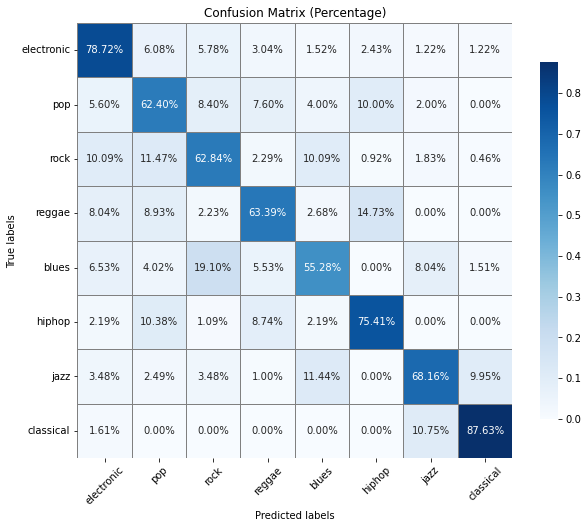

In [5]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Convert predictions to RDD
predictionAndLabels = predictions.select("prediction", "indexedLabel").rdd

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Confusion matrix
conf_matrix = metrics.confusionMatrix().toArray()

import numpy as np

# Normalize confusion matrix
conf_matrix_normalized = conf_matrix / conf_matrix.sum(axis=1).reshape(-1, 1)

import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2%", cmap='Blues', square=True, cbar_kws={"shrink": .82}, linewidths=.5, linecolor='grey')

# Labels, title and ticks
label_names = labelIndexer.labels
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.title('Confusion Matrix (Percentage)')
plt.xticks(np.arange(len(label_names)) + 0.5, label_names, rotation=45)
plt.yticks(np.arange(len(label_names)) + 0.5, label_names, rotation=0)

# Show the plot
plt.show()

